<a href="https://colab.research.google.com/github/Ben-Rapkin-Oberlin/374-Final-Project/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import numpy as np
from google.colab import drive
import os
from PIL import Image as im

#for saving and loading
drive.mount('/content/gdrive')

#load data
x_train= tfds.load('div2k/realistic_wild_x4',split='train[:100%]', as_supervised=True, shuffle_files=True)
valid= tfds.load('div2k/realistic_wild_x4',split='validation[:100%]', as_supervised=True,shuffle_files=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#transform = T.ToPILImage()
def preprocess(x,y):
  #y is high res image, x is low res
  tensor2 = tf.cast(tf.image.resize(y, [512, 512]), tf.uint8)

  #loose info
  tensor1 = tf.cast(tf.image.resize(tensor2, [128, 128]), tf.uint8)
  tensor1=tf.image.resize(tensor1, [512, 512])
  tensor1=tensor1/255 # normalize, but for images, pixels must be int
  # in the future it would be better to inplement a custom loss function that cast
  # the output as int before finding the mse
  #tensor1 = tf.cast(tensor1, tf.uint8)

  return tensor1, tensor2


x_train = x_train.map(lambda x,y: preprocess(x,y))
valid = valid.map(lambda x,y: preprocess(x,y))


In [ ]:
#ensure that the preproccessing worked
a=x_train.take(1).__iter__()
next_element = a.get_next()
b=next_element[0]
c=next_element[1]
low = im.fromarray(b.numpy(),'RGB')
high=im.fromarray(c.numpy(),'RGB')

display(low)
display(high)

# Training

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=14000)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

device_name = tf.test.gpu_device_name()
with tf.device(device_name):
  input_img = tf.keras.layers.Input(shape=(512, 512, 3))

  # Increase the number of filters in the convolutional layers to
  # better handle the increased resolution of the input and output images
  l1 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(input_img)
  l2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l1)
  l3 = tf.keras.layers.MaxPool2D(padding='same')(l2)

  l4 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l3)
  l5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l4)
  l6 = tf.keras.layers.MaxPool2D(padding='same')(l5)

  l7 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l6)

  # Add additional layers to handle the increased resolution of the input and output images
  l8 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l7)
  l9 = tf.keras.layers.UpSampling2D()(l8)
  l10 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l9)
  l11 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l10)

  l12 = tf.keras.layers.add([l11, l5])

  # Add additional layers to handle the increased resolution of the input and output images
  l13 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l12)
  l14 = tf.keras.layers.UpSampling2D()(l13)
  l15 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l14)
  l16 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l15)

  l17 = tf.keras.layers.add([l16, l2])

  decoded_image = tf.keras.layers.Conv2D(3, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l17)

  auto_encoder = tf.keras.models.Model(inputs=(input_img), outputs=decoded_image)
  #auto_encoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['MeanSquaredError'])
  auto_encoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['MeanSquaredError'])

Virtual devices cannot be modified after being initialized


In [ ]:
#batch the data
x_train=x_train.batch(4)
valid=valid.batch(4)

#load model
path = F"/content/gdrive/My Drive/autoencoder" 
try:
  auto_encoder.load_weights(path)
  print('prior found')
except:
  print('no prior')

#set saving system
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                 save_best_only=True,
                                                 #save_freq=1,
                                                 verbose=1, 
                                                 #monitor='val_mean_squared_error'
                                                 monitor='val_loss',
                                                 jit_compile=True                                
                                                 )

#fit model
history=auto_encoder.fit(
    x=x_train,
    validation_data=valid,
    #validation_steps=4,
    epochs=100,
    
    callbacks=[cp_callback])

#history.history

prior found
Epoch 1/100
800/800 [==============================] - ETA: 0s - loss: 531.5959 - mean_squared_error: 531.1368
Epoch 1: val_loss improved from inf to 480.48141, saving model to /content/gdrive/My Drive/autoencoder


800/800 [==============================] - 1254s 2s/step - loss: 531.5959 - mean_squared_error: 531.1368 - val_loss: 480.4814 - val_mean_squared_error: 480.0096
Epoch 2/100
800/800 [==============================] - ETA: 0s - loss: 486.8304 - mean_squared_error: 486.3657
Epoch 2: val_loss improved from 480.48141 to 471.64075, saving model to /content/gdrive/My Drive/autoencoder


800/800 [==============================] - 1210s 2s/step - loss: 486.8304 - mean_squared_error: 486.3657 - val_loss: 471.6407 - val_mean_squared_error: 471.1898
Epoch 3/100
800/800 [==============================] - ETA: 0s - loss: 473.2351 - mean_squared_error: 472.7873
Epoch 3: val_loss improved from 471.64075 to 466.04630, saving model to /content/gdrive/My Drive/autoencoder


800/800 [==============================] - 1210s 2s/step - loss: 473.2351 - mean_squared_error: 472.7873 - val_loss: 466.0463 - val_mean_squared_error: 465.6193
Epoch 4/100
 17/800 [..............................] - ETA: 19:31 - loss: 464.1411 - mean_squared_error: 463.7034

tf.Tensor([0.24313726 0.33333334 0.5254902 ], shape=(3,), dtype=float32)
1/1 [==============================] - 0s 283ms/step
[52.257957 73.70793  99.76114 ]
[ 63.58621  99.54827 135.9843 ]
[52 73 99]
[ 63  99 135]
[132 137 151]
[100 132 212]


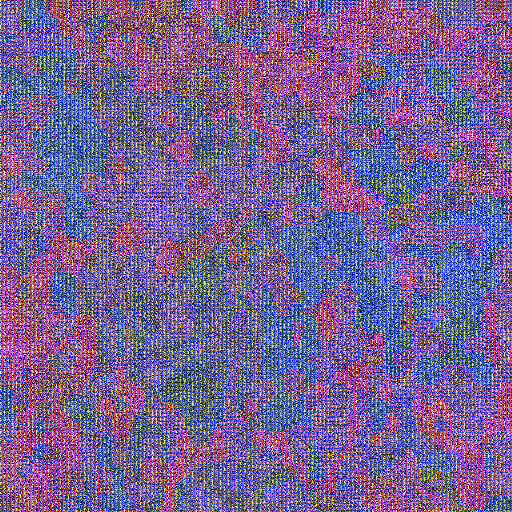

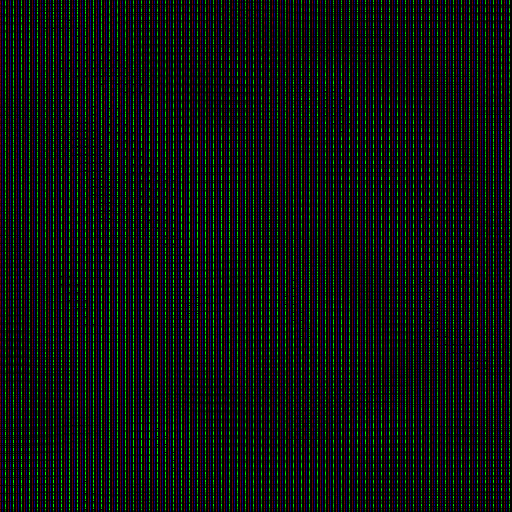

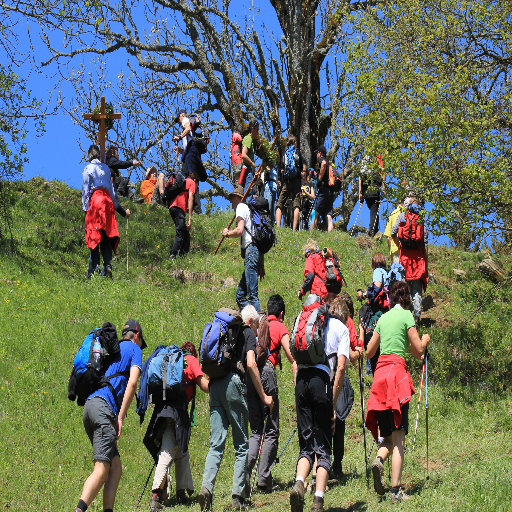

In [8]:
#test the model's output after some training
x_train=x_train.batch(1)
a=x_train.take(1).__iter__()
next_element = a.get_next()
test=next_element[0]
label=next_element[1]
label=label[0]
path = F"/content/gdrive/My Drive/autoencoder" 
auto_encoder.load_weights(path)
#print(test.shape)
print(test[0][0][0])
#print(test[1][1])

new=auto_encoder.predict(test)
new=new[0]

print(new[0][0])
print(new[1][1])

new=new.astype(int)
label=label.numpy()

print(new[0][0])
print(new[1][1])
print(label[0][0])
print(label[1][1])



label=im.fromarray(label,'RGB')
new=im.fromarray(new,'RGB')
test=im.fromarray(test[0].numpy(),'RGB')

display(test)
display(new)
display(label)

# Testing

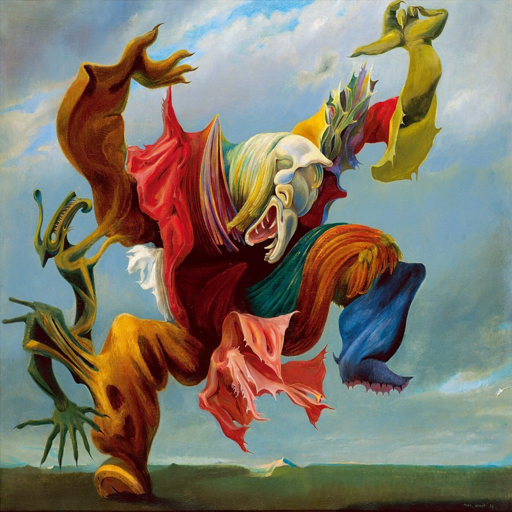

In [ ]:
from PIL import Image as im
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
import os
print(os.listdir("."))

img = im.open("./The Fireside Angel (The Triump)-Max Ernst.jpg")
img = img.convert('RGB')
display(img.resize((512,512)))
test=np.array(img)


1/1 [==============================] - 88s 88s/step
<class 'numpy.ndarray'>
(512, 512, 3)


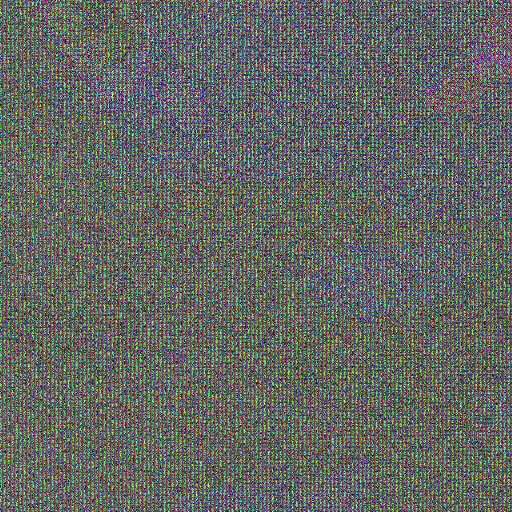

In [ ]:
from PIL import Image as im
path = F"/content/gdrive/My Drive/autoencoder" 
auto_encoder.load_weights(path)
x_train=x_train.batch(8)
new=auto_encoder.predict(x_train)
new=new[0]
print(type(new))
print(new.shape)
new = im.fromarray(new,'RGB')
display(new)
#tfds.as_dataframe(new.take(3),info)

<class 'tuple'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(339, 510, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1356, 2040, 3)


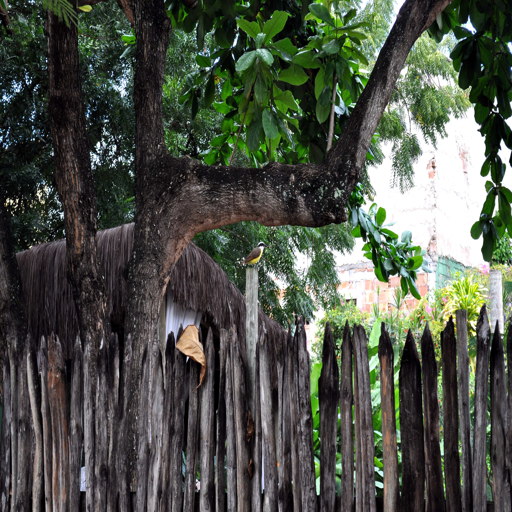

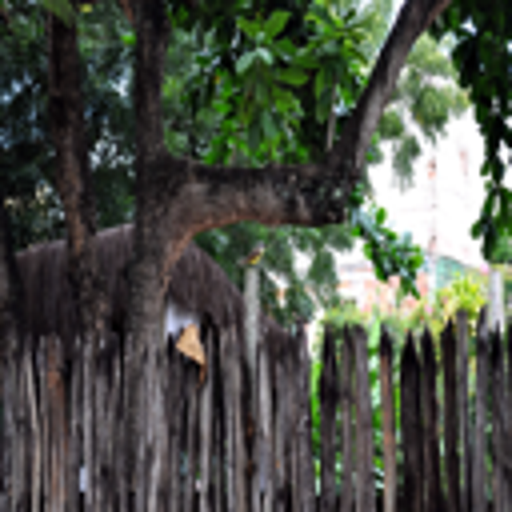

"\n#display(new)\na=new.resize((512, 512))\nb=new.resize((128, 128))\nb = np.array(b)\nb = im.fromarray(b,'RGB')\nb=b.resize((512, 512))\n#ni.noise(random)\ndisplay(a)\ndisplay(b)\nb = np.array(b)\na = np.array(a)\n#with ni(b) as b:\n # ni.noise(random)\n # display(b)\n\n#tensor2 = tf.image.resize(next_element[0], (512, 512))\n#tensor2=tensor2/255\n#new = im.fromarray(tensor2.numpy(),'RGB')\n#display(new)\n#new_image = image.resize((400, 400))\n#pt = next_element[0]\n#en = next_element[1]\n#print(pt.numpy())\n#print(en.numpy())\n#tfds.as_dataframe(x_train.take(3),info)\nprint(a[0][0])\nprint(b[0][0])\n"

In [6]:
#!pip install Wand
#from wand.image import Image as ni


a=x_train.take(1).__iter__()
next_element = a.get_next()
print(type(next_element))
print(type(next_element[0]))
print(next_element[0].shape)
print(type(next_element[1]))
print(next_element[1].shape)
first = im.fromarray(next_element[0].numpy(),'RGB')
second= im.fromarray(next_element[1].numpy(),'RGB')
first=first.resize((512, 512))
second=second.resize((512,512))
#display(first)
display(second)
b=second.resize((128, 128))
b = np.array(b)
b = im.fromarray(b,'RGB')
b=b.resize((512, 512))
display(b)

"""
#display(new)
a=new.resize((512, 512))
b=new.resize((128, 128))
b = np.array(b)
b = im.fromarray(b,'RGB')
b=b.resize((512, 512))
#ni.noise(random)
display(a)
display(b)
b = np.array(b)
a = np.array(a)
#with ni(b) as b:
 # ni.noise(random)
 # display(b)

#tensor2 = tf.image.resize(next_element[0], (512, 512))
#tensor2=tensor2/255
#new = im.fromarray(tensor2.numpy(),'RGB')
#display(new)
#new_image = image.resize((400, 400))
#pt = next_element[0]
#en = next_element[1]
#print(pt.numpy())
#print(en.numpy())
#tfds.as_dataframe(x_train.take(3),info)
print(a[0][0])
print(b[0][0])
"""

(1, 512, 512, 3)
1/1 [==============================] - 11s 11s/step
(1, 512, 512, 3)
<class 'numpy.ndarray'>
(512, 512, 3)


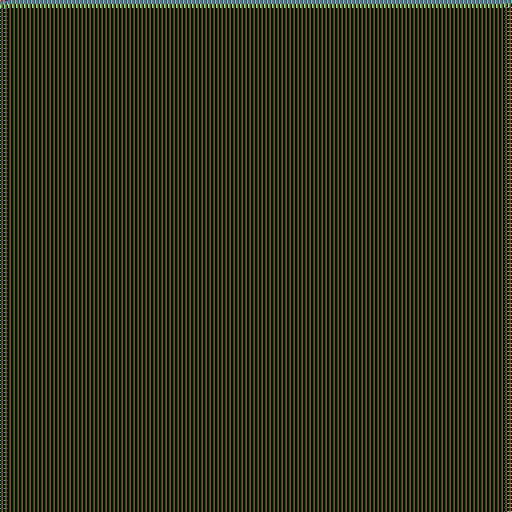

In [ ]:
import numpy as np
import tensorflow as tf
img2=np.asarray(img2)/255
img2=tf.convert_to_tensor(img2)
print(img2.shape)
img2=tf.reshape(img2, [1,512,512,3])
path = F"/content/gdrive/My Drive/autoencoder" 
auto_encoder.load_weights(path)
new=auto_encoder.predict(img2)
print(new.shape)
#new=tf.reshape(new, [512,512,3])
new=new[0]
#new=new.numpy()
print(type(new))
print(new.shape)

new = im.fromarray(new,'RGB')
display(new)

In [ ]:
div2k